In [1]:
# General imports and widgets
import os
import sys
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15
warnings.simplefilter("ignore")

import ipywidgets as widgets




In [2]:
if os.getcwd()[-13:]!='deepARTransit':
    print('ok')
    os.chdir(os.path.join('/','Users','mario','git-repos','deepARTransit'))
    
project_dir = '.'

ok


### Loading real times

In [3]:
def radial_aperture(array, cent, radius=3):
    aperture = np.empty_like(array, dtype=bool)
    if len(array.shape) == 2:
        aperture[:,:] = False
        for i in np.arange(array.shape[-2]):
            for j in np.arange(array.shape[-1]) :
                if (i + 0.5 - cent[0]) ** 2 + (j + 0.5  -cent[1]) ** 2 <= radius ** 2:
                    aperture[i,j] = True
    elif len(array.shape) == 3:
        aperture[:,:,:] = False
        for t in range(array.shape[0]):
            for i in np.arange(array.shape[-2]):
                for j in np.arange(array.shape[-1]) :
                    if (i + 0.5 - cent[0]) ** 2 + (j + 0.5  -cent[1]) ** 2 <= radius ** 2:
                        aperture[t, i,j] = True
    return aperture

In [4]:
mask = ~radial_aperture(np.ones(shape=(32,32)), (16,16), 16)

In [5]:
channel = 4
from spitzerlc.observation import Observation
from spitzerlc.data_handling import load_data
time_arrays = np.zeros(shape=(6, 690))
background_mean = []
bts = []
aorkey_list = ['22807296', '22807552', '22807808', '24537856', '27603712', '27773440']
for i,aorkey in enumerate(aorkey_list):
    time_array, flux, header = load_data(aorkey, channel, parent_dir = '/Users/mario/git-repos/spitzerLC/spitzerlc/data/agol_hd189733b/')
    obs = Observation(aorkey, channel, header, time_array, flux )
    time_arrays[i] = obs.time_array
    
    #background_mean.append(np.nanmedian(obs.flux[200:500,mask], axis=1).mean()*25)
    bts.append(np.nanmedian(obs.flux[:,mask], axis=1) * 25)
    
    #print('background estimate', background_mean[-1])
    plt.plot(bts[-1])
    plt.show()
    
    obs.select_subregion(radius=2)
    plt.plot(obs.raw_light_curve().flux)
    plt.show()   
    plt.plot(obs.raw_light_curve().flux - bts[-1])
    plt.show()
    
    print((bts[-1][:300]/obs.raw_light_curve().flux[:300]).min(), 
          (bts[-1][:300]/obs.raw_light_curve().flux[:300]).max())
time_arrays = time_arrays - 2454000


loaded data from /Users/mario/git-repos/spitzerLC/spitzerlc/data/agol_hd189733b/r22807296/ch4/bcd
0.007300938369782203 0.007814184134924636
loaded data from /Users/mario/git-repos/spitzerLC/spitzerlc/data/agol_hd189733b/r22807552/ch4/bcd
0.007176474198492989 0.007585800264548908
loaded data from /Users/mario/git-repos/spitzerLC/spitzerlc/data/agol_hd189733b/r22807808/ch4/bcd
0.00668473546154618 0.007300206732308482
loaded data from /Users/mario/git-repos/spitzerLC/spitzerlc/data/agol_hd189733b/r24537856/ch4/bcd
0.009042642781826022 0.0098048980406512
loaded data from /Users/mario/git-repos/spitzerLC/spitzerlc/data/agol_hd189733b/r27603712/ch4/bcd
0.011446717848906092 0.012102170757059877
loaded data from /Users/mario/git-repos/spitzerLC/spitzerlc/data/agol_hd189733b/r27773440/ch4/bcd
0.010489071981656163 0.012074972880858953


In [6]:
   
experiment_widget = widgets.Dropdown(
    options=sorted(list({r.split('experiments')[1][1:] for r,d,f in os.walk('./experiments') if 'output' in d and 'summary' in d})),
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

In [7]:
experiment_widget

Dropdown(description='\t\t', options=('cobweb/agol_all_transits', 'cobweb/agol_all_transits_4cent', 'cobweb/ag…

In [38]:
from deepartransit.utils.config import get_config_file, process_config
from deepartransit.data_handling import data_generator
from deepartransit.utils.transit import get_transit_model

experiment_folder = experiment_widget.value
experiment_dir = os.path.join('experiments', experiment_folder)
config_file = get_config_file(experiment_dir)

config = process_config(config_file)
data = data_generator.DataGenerator(config)
config = data.update_config()

t1, t2, t3 = config['pretrans_length'], config['trans_length'], config['postrans_length']
n_obs = data.Z.shape[0]

add_noise defaulted to False
defaulting adapt range to True
defaulting start adapt frac to 0.5
loading data from deepartransit/data/agol_transits_nobacksub/rlc_agol_transits_r2.npy
(6, 690, 1) (6, 690, 4)
time_path parameter not found in config. Default to 0,1,2....T-1
Inferring num_features, num_cov, num_ts from the data.


### Plotting input data

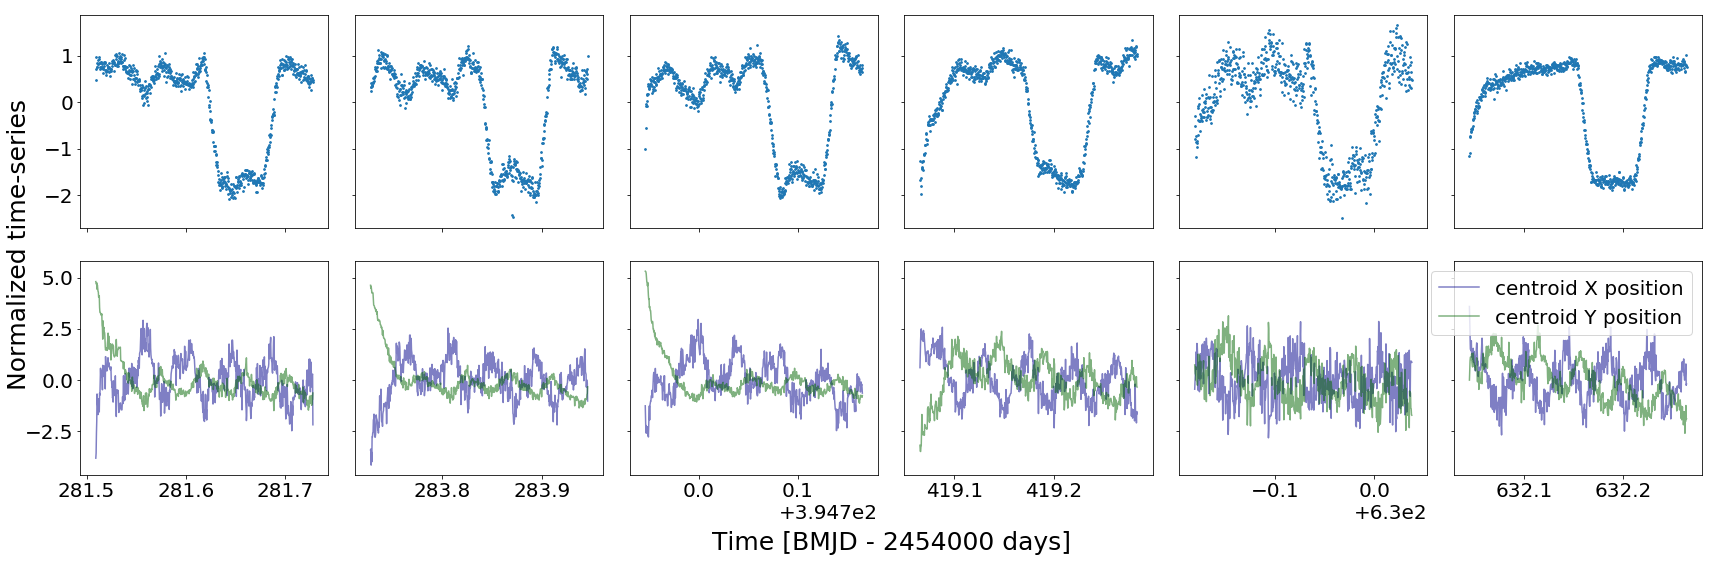

In [39]:
%matplotlib inline
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(2, n_obs, figsize=(25,10), sharey='row', sharex='col')
Z_orig = data.scaler_Z.inverse_transform(data.Z)
for obs in range(n_obs):
    ax[0, obs].scatter(time_arrays[obs], data.Z[obs,:,0], 
                       s=3, label='raw light curve')
    ax[1, obs].plot(time_arrays[obs], data.X[obs,:,0], label='centroid X position', color='darkblue', alpha=0.5)
    ax[1, obs].plot(time_arrays[obs], data.X[obs,:,1], label='centroid Y position', color='darkgreen', alpha=0.5)
plt.tight_layout()
plt.legend()

#ax[0,obs].set_ylim( np.quantile(Z_orig, 0.03)*0.99, 1.01*np.quantile(Z_orig, 0.99))

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.margins(x = 1)
plt.xlabel("Time [BMJD - 2454000 days]", fontsize=25, labelpad=30)
plt.subplots_adjust(bottom=0.8)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.margins(x = 1)
plt.ylabel("Normalized time-series", fontsize=25, labelpad=10)
#plt.subplots_adjust(bottom=0.8)
plt.show()

plt.show()


# Loading results

In [40]:
# retrieve evaluation steps
loc_dict = {}
pars_dict = {}
scale_dict = {}
for fn in [s for s in os.listdir(os.path.join(project_dir, config.output_dir)) if (s[:3] == 'loc')]:
    step = fn.split('_')[-1].split('.')[0]
    try:
        loc_dict[int(step)] = np.load(os.path.join(project_dir, config.output_dir, fn)).swapaxes(0,1)#.mean(axis=0)
        scale_dict[int(step)] = np.load(os.path.join(project_dir, config.output_dir, 'scales_array_{}.npy'.format(step))).swapaxes(0,1)#.mean(axis=0)
    except:
        print(fn)
        break
step_list = sorted([int(k) for k in loc_dict if k!='array'])
print(step_list)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900]


In [41]:
step = step_list[-3]
step = 3150

In [42]:
loc_array = loc_dict[step]

In [43]:
def to_real_time(t, true_ta, wrong_ta):
    return true_ta[0] + t * (true_ta[-1] - true_ta[0]) / (wrong_ta[-1] - wrong_ta[0])

time_arrays[0].shape, data.time_array[obs].shape

((690,), ())

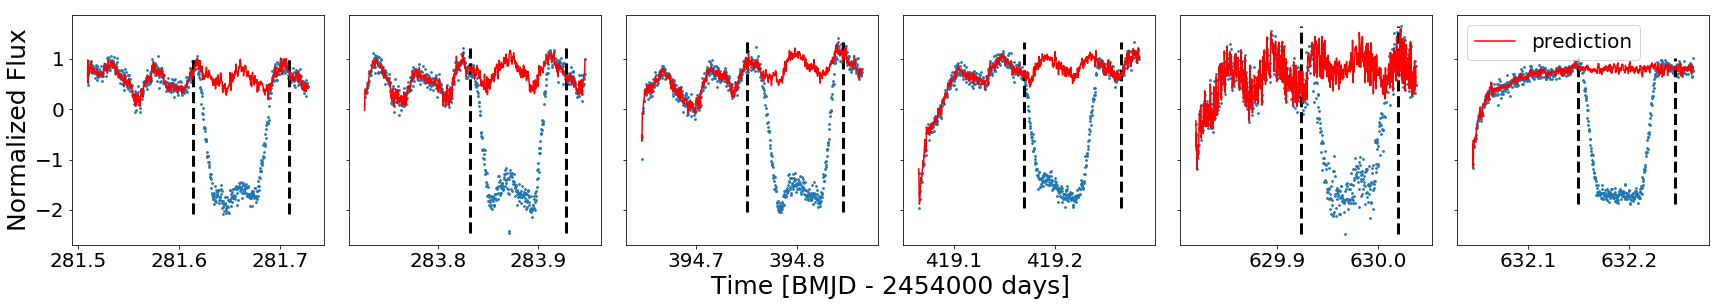

In [44]:
fig, ax = plt.subplots(1, n_obs, figsize=(25,5), sharey='row')
for obs in range(n_obs):
    ax[obs].scatter(time_arrays[obs], data.Z[obs,:,0], s=3)
    ax[obs].plot(time_arrays[obs], loc_array[obs,:,0], label='prediction', color='red')#, linewidth=0.2/loc_array[obs,200:,0].std())
    ax[obs].ticklabel_format(axis='x',style='plain', useOffset=False)

    m, M = data.Z[obs,:,0].min(), data.Z[obs,:,0].max()
    ax[obs].vlines(to_real_time(t1-1, time_arrays[obs], data.time_array), 
                   m, M, 'black', linewidth=3, linestyles='dashed')
    ax[obs].vlines(to_real_time(t1+t2 + 1, time_arrays[obs], data.time_array), 
                   m, M, 'black', linewidth=3, linestyles='dashed')    
    
#plt.tight_layout()
ax[-1].legend()
ax[0].set_ylabel('Normalized Flux', fontsize=25)


#fig.add_subplot(111, frameon=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.margins(x = 1)
#plt.xlabel("Time [BMJD - 2454000 days]", fontsize=25, labelpad=30)
#plt.show()
#ax2 = plt.gca()
#plt.xaxis.set_label_coords(0.5, 1.07) 
#plt.show()

ax1 = fig.add_subplot(111, frameon=False)
#ax2 = ax1.twinx()
# hide tick and tick label of the big axis


        
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.margins(x = 1)
plt.xlabel("Time [BMJD - 2454000 days]", fontsize=25, labelpad=-30)
#ax2 = plt.gca()
ax1.xaxis.set_label_coords(0.5, -0.13)    

# Fitting


### Linear Transit

2.39
2.39
2.41
2.41
2.43
2.39


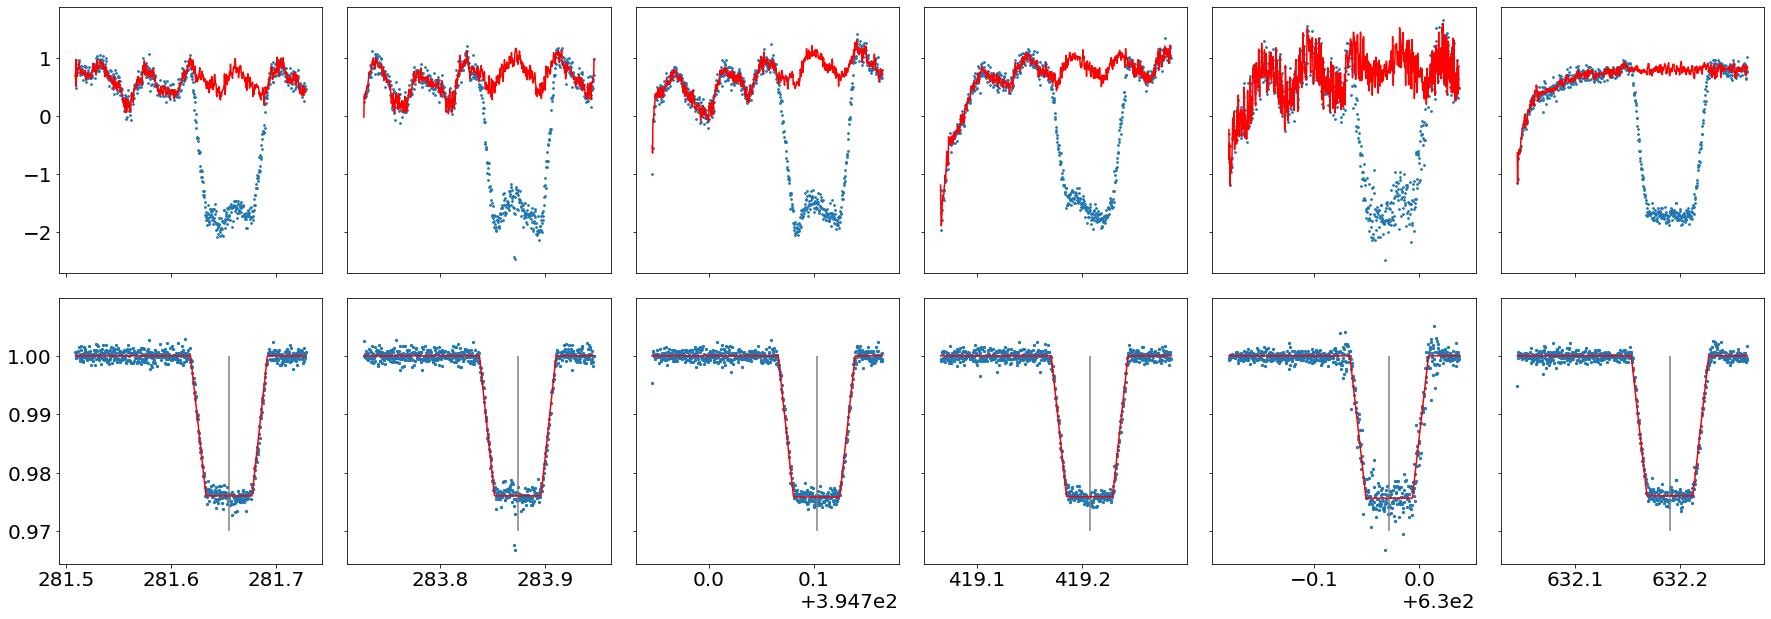

In [45]:
from deepartransit.utils.transit import LinearTransit
f, ax = plt.subplots(2, n_obs, figsize=(25,9), sharey='row', sharex='col')

transit_component = np.zeros(shape=data.Z.shape)

ltransits = []
for obs in range(n_obs):
    
    transit_component[obs] = ((data.scaler_Z.inverse_transform(data.Z)[obs,:,0]-bts[obs])
                         / (data.scaler_Z.inverse_transform(loc_array)[obs,:,0]-bts[obs]))[:,np.newaxis]
    
    #y = (data.scaler_Z.inverse_transform(loc_array)[obs]
    #x = (data.scaler_Z.inverse_transform(data.Z)[obs])
    #x - y / (y - b) 
         
    ax[0, obs].scatter(time_arrays[obs], data.Z[obs,:,0], s=3)
    ax[0, obs].plot(time_arrays[obs], loc_array[obs,:,0], label='prediction', color='red')
    ax[1, obs].scatter(time_arrays[obs], transit_component[obs,:,0], s=5)
    
    ltransit = LinearTransit(data.time_array)
    ltransit.fit(transit_component[obs,:,0], time_axis=0)
    ax[1, obs].plot(time_arrays[obs], ltransit.flux, label='prediction', color='red')
    print('{:.2f}'.format(ltransit.delta*100))
    #ax[1, obs].plot(time_arrays[obs], transit.flux, color='red', label='best fit', linewidth=5, alpha=0.9)
    mid_time = time_arrays[obs, 0] + ltransit.t_c * (time_arrays[obs, -1] - time_arrays[obs, 0]) / (data.time_array[-1] - data.time_array[0])
    ax[1, obs].vlines(mid_time, 0.97, 1, color='grey')

In [46]:
from pylightcurve import find_oec_parameters
(planet, logg, effective_temperature, metallicity, rp_over_rs, fp_over_fs,
 period, sma_over_rs, eccentricity, inclination, periastron, mid_time) = find_oec_parameters('hd189733b')


In [138]:
from pylightcurve import TransitAndPolyFitting
import pandas as pd

fitting_list = []
ma_width = 50
mstd_width = 4

i = 0
fitting_folder = 'results_fitting_' + str(i)
while os.path.exists(os.path.join(experiment_dir, fitting_folder)):
    i += 1
    fitting_folder = 'results_fitting_' + str(i)
os.mkdir(os.path.join(experiment_dir, fitting_folder))

for obs in range(n_obs):
    # estimate mid_time from linear fit
    mid_time = time_arrays[obs, 0] + ltransit.t_c * (time_arrays[obs, -1] - time_arrays[obs, 0]) / (data.time_array[-1] - data.time_array[0])
    #x = (data.scaler_Z.inverse_transform(data.Z)[obs,:,0])
    #y = (x / pd.Series(x).rolling(ma_width,1).mean())
    y = pd.Series(transit_component[obs,:,0])
    err = np.append(y[:5].std(), y.rolling(mstd_width,1).std().values[1:])
    print(err.mean())
    transitFittingObject = TransitAndPolyFitting(data=[[time_arrays[obs], 
                                                        transit_component[obs,:,0],
                                                        err
                                                ]],
                                                method='linear',
                                                limb_darkening_coefficients=[0.15],
                                                rp_over_rs=rp_over_rs,
                                                period=period,
                                                sma_over_rs=sma_over_rs,
                                                eccentricity=eccentricity,
                                                inclination=inclination,
                                                periastron=periastron,
                                                mid_time = mid_time,
                                                iterations= 300_000,
                                                walkers= 300,
                                                burn= 70_000,
                                                precision=3,
                                                exp_time=0.,
                                                time_factor=1,
                                                fit_first_order=False,
                                                fit_second_order=False,
                                                fit_rp_over_rs=[0.1, 0.2],
                                                fit_period=False,
                                                fit_sma_over_rs = [sma_over_rs-1, sma_over_rs+1],
                                                fit_eccentricity = False,
                                                fit_inclination = [inclination-3,inclination+3],
                                                fit_periastron = False,
                                                fit_mid_time = [mid_time - period /50, mid_time + period/50],
                                                fit_ld=[[0.05,0.25]],
                                                counter=True,
                                                counter_window=False)
    transitFittingObject.fit_ld = True
    transitFittingObject.run_mcmc()
    fitting_list.append(transitFittingObject.results)
    
    # Just printing
    rp_over_rs_new = transitFittingObject.results['parameters']['rp']
    print('Rp/Rs = {:.5f} -{:.6f}/+{:.6f}'.format(rp_over_rs_new['value'], 
                                                  rp_over_rs_new['m_error'], 
                                                  rp_over_rs_new['p_error']))
    print('(Rp/Rs)**2 = {:.5f} -{:.6f}/+{:.6f}'.format(rp_over_rs_new['value']**2, 
                                                       np.abs(2 * rp_over_rs_new['m_error'] * rp_over_rs_new['value']), 
                                                       np.abs(2 * rp_over_rs_new['p_error'] * rp_over_rs_new['value'])))
    
    # Just saving

    transitFittingObject.save_all(os.path.join(experiment_dir, fitting_folder, f'simulation_data_base_{obs}.pickle'))
    transitFittingObject.save_results(os.path.join(experiment_dir,fitting_folder, f'simulation_resultsobs_{obs}.txt'))
    transitFittingObject.plot_corner(os.path.join(experiment_dir,fitting_folder, f'simulation_correlations_{obs}.pdf'))
    transitFittingObject.plot_traces(os.path.join(experiment_dir,fitting_folder, f'simulation_traces_{obs}.pdf'))

0.0007947461179369635
MCMC...........: 300300 / 300300    time left: 0:00:00   total time: 0:06:32
Rp/Rs = 0.15489 -0.000158/+0.000181
(Rp/Rs)**2 = 0.02399 -0.000049/+0.000056
0.0008345668857369273
MCMC...........: 300300 / 300300    time left: 0:00:00   total time: 0:05:46
ERROR : confidence level can not be reached from left
Rp/Rs = 0.15477 -0.000160/+0.000240
(Rp/Rs)**2 = 0.02395 -0.000050/+0.000074
0.0007507048409689427
MCMC...........: 300300 / 300300    time left: 0:00:00   total time: 0:06:04
Rp/Rs = 0.15564 -0.000176/+0.000201
(Rp/Rs)**2 = 0.02422 -0.000055/+0.000063
0.0007400134408044317
MCMC...........: 300300 / 300300    time left: 0:00:00   total time: 0:06:17
Rp/Rs = 0.15520 -0.000155/+0.000155
(Rp/Rs)**2 = 0.02409 -0.000048/+0.000048
0.0011969830135751456
MCMC...........: 300300 / 300300    time left: 0:00:00   total time: 0:06:03
ERROR : confidence level can not be reached from right
Rp/Rs = 0.15523 -0.000283/+0.000425
(Rp/Rs)**2 = 0.02410 -0.000088/+0.000132
0.000707437

In [ ]:
# Reloadinf saved results
import pickle
fitting_folder = 'results_fitting_11'
with open(os.path.join(experiment_dir, fitting_folder, f'simulation_data_base_{obs}.pickle'), 'rb') as pick_file:
    transitFittingObject = pickle.load(pick_file)

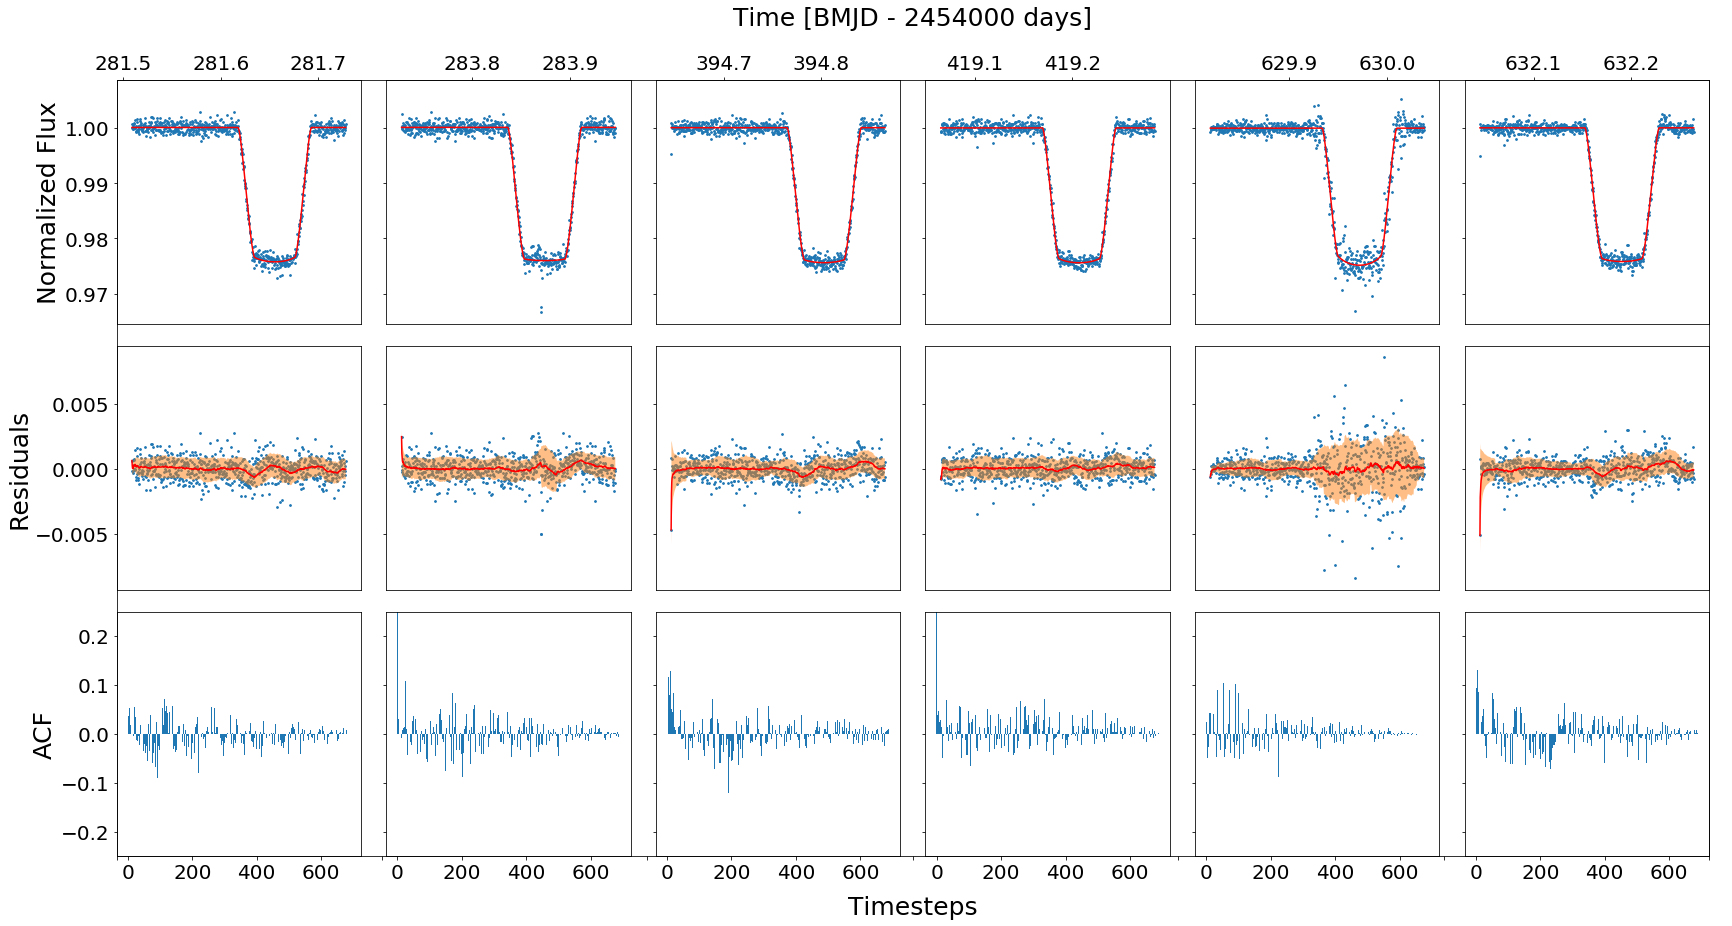

In [139]:
fig, ax = plt.subplots(3, n_obs, figsize=(25,14), sharey='row') #, sharex='col')
rol_win = 50
for obs in range(n_obs):
    ax[0,obs].scatter(time_arrays[obs], transit_component[obs,:,0], s=3)
    ax[0,obs].plot(time_arrays[obs], fitting_list[obs]['output_series']['model'], color='red', label='mcmc fit')
    
    res = fitting_list[obs]['output_series']['residuals']
    if obs==1:
        res = res.clip(-0.005, 0.005)
    ax[1,obs].scatter(time_arrays[obs], res, s=3)

    ma_res = pd.Series(res).rolling(rol_win, min_periods=1).mean().values
    mstd_res = pd.Series(res).rolling(rol_win, min_periods=1).std().values
    ax[1,obs].plot(time_arrays[obs], ma_res, color='red')
    ax[1,obs].fill_between(time_arrays[obs], ma_res - mstd_res, ma_res+mstd_res, alpha=0.5)

    ax[0,obs].ticklabel_format(axis='x',style='plain', useOffset=False)
    ax[1,obs].ticklabel_format(axis='x',style='plain', useOffset=False)
    ax[0,obs].tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)
    ax[1,obs].tick_params(labeltop=False, labelbottom=False, top=False, bottom=False)
    ax[2, obs].bar(range(690),fitting_list[obs]['detrended_statistics']['res_autocorr'] )

ax[0, 0].set_ylabel('Normalized Flux', fontsize=25)
ax[1, 0].set_ylabel('Residuals', fontsize=25)
ax[2, 0].set_ylabel('ACF', fontsize=25)
ax[2, 0].set_ylim(-0.25,0.25)
    
ax1 = fig.add_subplot(111, frameon=False)
#ax2 = ax1.twinx()
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.margins(x = 1)
plt.xlabel("Timesteps", fontsize=25, labelpad=-30)
#ax2 = plt.gca()
ax1.xaxis.set_label_coords(0.5, -0.05)     
    
    
#ax2 = fig.add_subplot(111, frameon=False)
ax2 = ax1.twiny()
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.margins(x = 1)
plt.xlabel("Time [BMJD - 2454000 days]", fontsize=25, labelpad=-30)
#ax2 = plt.gca()
ax2.xaxis.set_label_coords(0.5, 1.07) 
#ax.set_xlabel('xlabel', ha='left', va = 'top', )
#plt.subplots_adjust(bottom=0.8)



In [140]:
# Defining weighted avg function, which computes both weighted average and std of this weighted average
def weighted_avg(x, sigma):
    x = np.array(x)
    sigma = np.array(sigma)
    try:
        if sigma.shape[1] == 2:
            sigma = sigma.mean(1)
    
    except IndexError:
        pass
    print(x.shape,sigma.shape)
    assert x.shape == sigma.shape
    
    weights = 1 / (np.array(sigma)**2)
    weighted_mean_delta = np.sum((x * weights )) / weights.sum()
    std_weighted_mean_delta = np.sqrt(1 / weights.sum())

    return weighted_mean_delta, std_weighted_mean_delta

(6,) (6,)


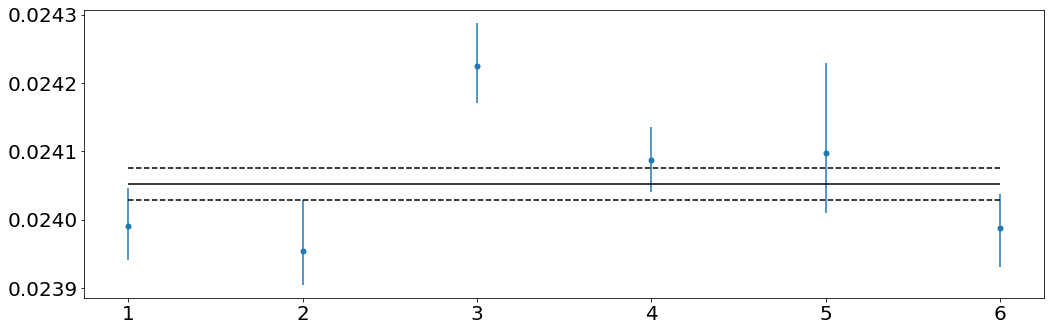

In [141]:
plt.figure(figsize=(15,5))

deltas = np.array([fitting_list[obs]['parameters']['rp']['value']**2 for obs in range(n_obs)])
deltas_errors = np.array([[fitting_list[obs]['parameters']['rp']['m_error']* rp_over_rs_new['value'] * 2,
        fitting_list[obs]['parameters']['rp']['p_error']* rp_over_rs_new['value'] * 2] 
       for obs in range(n_obs)])


mu, sigmu = weighted_avg(deltas, deltas_errors)
plt.errorbar(range(1, n_obs+1), 
             deltas, 
             yerr=deltas_errors.T,
             markersize=5, fmt='o',)
plt.hlines(mu, 1,6 , color= 'black')
plt.hlines(mu-sigmu, 1,6, linestyle='dashed', color= 'black')
plt.hlines(mu+sigmu, 1,6, linestyle='dashed', color= 'black')



rp
0 0
(6,) (6,)
ldc1
0 1
(6,) (6,)
a
1 0
(6,) (6,)
i
1 1
(6,) (6,)


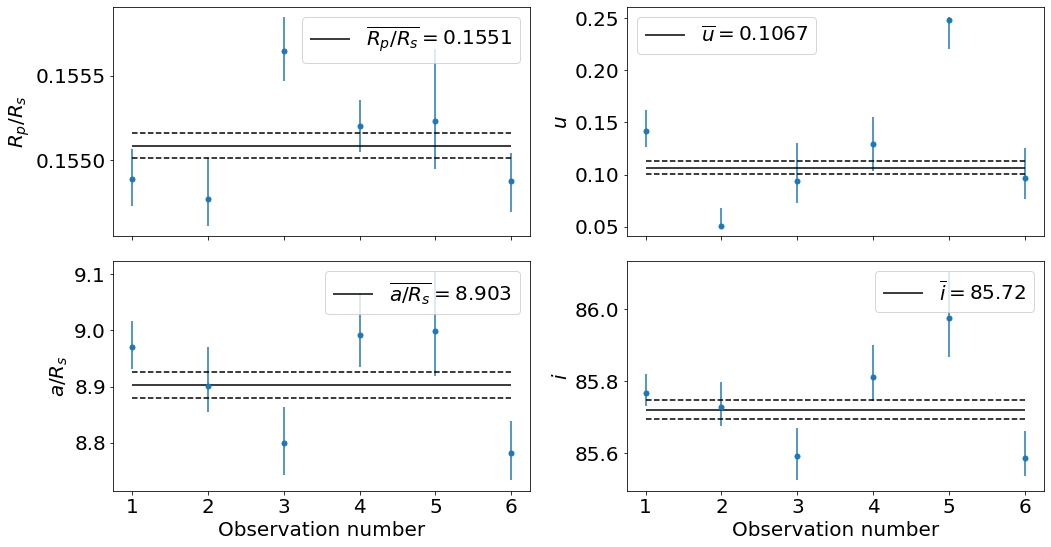

In [142]:
par_names_pylc = ['rp', 'ldc1', 'a','i']
par_names = ['$R_p/R_s$', '$u$', '$a/R_s$','$i$']
weighted_mu_dict = {}
f,ax = plt.subplots(len(par_names)//2,len(par_names)//2, figsize=(15, 8), sharex='col')
for i, parameter in enumerate(par_names_pylc):
    print(parameter)
    #param = fitting_list[obs]['parameters'][]
    
    par_values = [fitting_list[obs]['parameters'][parameter]['value'] for obs in range(n_obs)]
    par_errors = np.array([[fitting_list[obs]['parameters'][parameter]['m_error'],
                            fitting_list[obs]['parameters'][parameter]['p_error']] for obs in range(n_obs)])
    ix = i//2
    iy = (i % 2)
    print(ix,iy)
    ax[ix,iy].errorbar(range(1, n_obs+1), par_values, yerr=par_errors.T, markersize=5, fmt='o')
    
    mu, sigmu = weighted_avg(par_values, par_errors)
    ax[ix,iy].hlines(mu, 1,6 , color= 'black', 
                     label="$\overline{{{}}}={:.4g}$".format(par_names[i][1:-1], mu))
    ax[ix,iy].hlines(mu-sigmu, 1,6, linestyle='dashed', color= 'black')
    ax[ix,iy].hlines(mu+sigmu, 1,6, linestyle='dashed', color= 'black')
    ax[ix,iy].legend()
    ax[ix,iy].set_ylabel(par_names[i], fontsize=20)
    
    weighted_mu_dict[parameter] = mu
    
ax[-1, 0].set_xlabel('Observation number', fontsize=20)
ax[-1, 1].set_xlabel('Observation number', fontsize=20)

plt.show()

# Latex Print

In [145]:
latex_string = ""
prec_val = [6,5,4,3,3]
for obs in range(6):
    latex_val_list = []
    latex_err_list = []
    for parameter in ['mt', 'rp', 'i', 'a', 'ldc1']:
        
        latex_val_list.append(fitting_list[obs]['parameters'][parameter]['value'])
        latex_err_list.append(max(fitting_list[obs]['parameters'][parameter]['m_error'], fitting_list[obs]['parameters'][parameter]['p_error']))
    
        if parameter == "mt":
            #latex_val_list[-1] -= 2454000
            pass
        #if parameter == 'rp':
        #    latex_val_list.append(100 * fitting_list[obs]['parameters']['rp']['value']**2)
        #    latex_err_list.append(100 * 2 * max(fitting_list[obs]['parameters'][parameter]['m_error'], 
        #                                  fitting_list[obs]['parameters'][parameter]['p_error']) *
        #                          fitting_list[obs]['parameters']['rp']['value'])
           
            
    #print(latex_val_list)
    #print(latex_err_list)            
    #"${{}}\pm{{}}$   & $ {}\pm{}$ & ${}\pm{}$ & $ \pm$ & $ 0.x\pm$ & $ 8x\pm$"
    #print()
    latex_string += '\t'*2
    latex_string += " & ".join(["${0:.{2}f}\pm{{{1:.{3}f}}}$".format(latex_val_list[i], 
                                                                     latex_err_list[i],
                                                                     prec_val[i],
                                                                     prec_val[i]
                                                                    ) for i in range(len(latex_val_list))])
    latex_string += ' \\\\\n'
print(latex_string)

		$281.655329\pm{0.000046}$ & $0.15489\pm{0.00018}$ & $85.7682\pm{0.0502}$ & $8.971\pm{0.045}$ & $0.141\pm{0.020}$ \\
		$283.873934\pm{0.000049}$ & $0.15477\pm{0.00024}$ & $85.7277\pm{0.0698}$ & $8.901\pm{0.069}$ & $0.051\pm{0.018}$ \\
		$394.802829\pm{0.000045}$ & $0.15564\pm{0.00020}$ & $85.5926\pm{0.0771}$ & $8.799\pm{0.065}$ & $0.093\pm{0.037}$ \\
		$419.206955\pm{0.000070}$ & $0.15520\pm{0.00015}$ & $85.8120\pm{0.0881}$ & $8.992\pm{0.075}$ & $0.129\pm{0.026}$ \\
		$629.971770\pm{0.000097}$ & $0.15523\pm{0.00042}$ & $85.9760\pm{0.1263}$ & $8.999\pm{0.106}$ & $0.248\pm{0.028}$ \\
		$632.190498\pm{0.000046}$ & $0.15488\pm{0.00019}$ & $85.5862\pm{0.0747}$ & $8.782\pm{0.057}$ & $0.097\pm{0.028}$ \\



In [146]:
# Just testing Latex rendering
from IPython.display import Latex
Latex(latex_string)

<IPython.core.display.Latex object>

In [147]:
# Old values
#lines = """
#        $281.655330\pm{0.000046}$ & $0.15488\pm{0.00018}$ & $2.3988\pm{0.0056}$ & $85.771\pm{0.049}$ & $8.966\pm{0.044}$ & $0.146\pm{0.020}$ \\
#		$283.873934\pm{0.000050}$ & $0.15482\pm{0.00021}$ & $2.3969\pm{0.0066}$ & $85.800\pm{0.070}$ & $8.951\pm{0.062}$ & $0.100\pm{0.011}$ \\
#		$394.802828\pm{0.000045}$ & $0.15563\pm{0.00020}$ & $2.4221\pm{0.0063}$ & $85.610\pm{0.077}$ & $8.818\pm{0.060}$ & $0.101\pm{0.034}$ \\
#		$419.206968\pm{0.000063}$ & $0.15514\pm{0.00018}$ & $2.4067\pm{0.0057}$ & $85.849\pm{0.073}$ & $9.002\pm{0.072}$ & $0.130\pm{0.028}$ \\
#		$629.971783\pm{0.000087}$ & $0.15554\pm{0.00034}$ & $2.4193\pm{0.0105}$ & $85.890\pm{0.115}$ & $8.949\pm{0.099}$ & $0.199\pm{0.018}$ \\
#		$632.190497\pm{0.000047}$ & $0.15480\pm{0.00021}$ & $2.3962\pm{0.0064}$ & $85.619\pm{0.063}$ & $8.788\pm{0.064}$ & $0.103\pm{0.024}$ \\
#""".split('\n')
#deltas_errors = []
#for line in lines[1:-1]:
#    print(line.split('&')[2][12:-3])
#    deltas_errors += [np.float64(line.split('&')[2][12:-3])]
#deltas_errors = np.array(deltas_errors)

## Plot with Agol

In [148]:
agol_deltas = np.array([2.4022, 2.4253, 2.4333, 2.4224, 2.3984, 2.3965])
agol_deltas_unc = np.array([47,63,51,49,62,74])/10_000
agol_deltas.shape, agol_deltas_unc.shape, deltas.shape, deltas_errors.shape

((6,), (6,), (6,), (6, 2))

In [153]:
# Scatter
agol_deltas.std(), np.array(deltas).std()

(0.014455612135853035, 9.17457702915252e-05)

In [154]:
deltas, agol_deltas

(array([0.02399032, 0.02395432, 0.02422485, 0.02408757, 0.02409698,
        0.02398767]), array([2.4022, 2.4253, 2.4333, 2.4224, 2.3984, 2.3965]))

In [158]:
wm, ws = weighted_avg(deltas*100, deltas_errors*100)
wma,wsa = weighted_avg(agol_deltas, agol_deltas_unc)

wm, wma, (wma - wm), (wma-wm)/ws

(6,) (6,)
(6,) (6,)


(2.405201917364714,
 2.4146005080785167,
 0.009398590713802779,
 3.9636977678898186)

(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)
(6,) (6,)


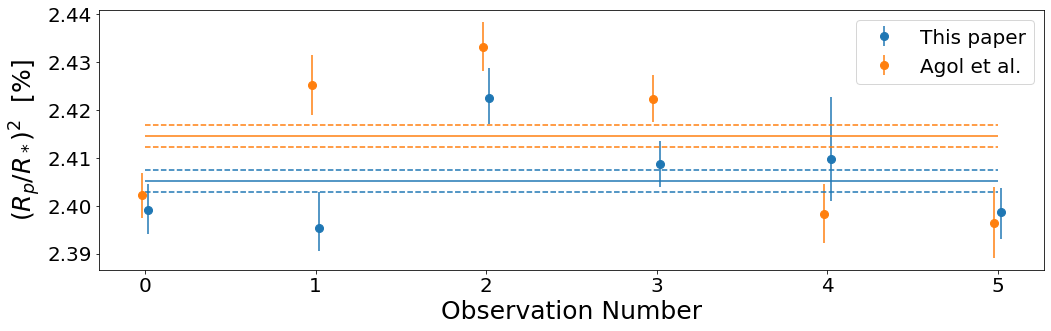

In [152]:
plt.figure(figsize=(15,5))
p = plt.errorbar(np.arange(6)+0.02, 100*np.array(deltas), yerr=100*deltas_errors.T, 
             fmt='o', label='This paper', markersize = 8)
p2 = plt.errorbar(np.arange(6)-0.02, agol_deltas, yerr=agol_deltas_unc,  markersize = 8,
             fmt='o', label='Agol et al.')


plt.hlines(weighted_avg(100*deltas, 100*deltas_errors)[0], 0,5 , color= p[0].get_color())
plt.hlines(weighted_avg(100*deltas, 100*deltas_errors)[0] + weighted_avg(100*deltas, 100*deltas_errors)[1], 
           0,5, linestyle='dashed', color= p[0].get_color())
plt.hlines(weighted_avg(100*deltas, 100*deltas_errors)[0] - weighted_avg(100*deltas, 100*deltas_errors)[1], 
           0,5, linestyle='dashed', color= p[0].get_color())


plt.hlines(weighted_avg(agol_deltas, agol_deltas_unc)[0], 0,5 , color= p2[0].get_color())
plt.hlines(weighted_avg(agol_deltas, agol_deltas_unc)[0] + weighted_avg(deltas, agol_deltas_unc)[1], 
           0,5, linestyle='dashed', color= p2[0].get_color())
plt.hlines(weighted_avg(agol_deltas, agol_deltas_unc)[0] - weighted_avg(deltas, agol_deltas_unc)[1], 
           0,5, linestyle='dashed', color= p2[0].get_color())


plt.legend()
plt.xlabel('Observation Number', fontsize=25)

plt.ylabel('$(R_p/R_*)^2$  $[\%]$', fontsize=25)
pass

## Second run with $i$, $u$ and $a/R_S$ fixed


In [37]:
fitting_list_2 = []
ma_width = 50
mstd_width = 5
for obs in range(n_obs):
    # estimate mid_time from linear fit
    mid_time = time_arrays[obs, 0] + ltransit.t_c * (time_arrays[obs, -1] - time_arrays[obs, 0]) / (data.time_array[-1] - data.time_array[0])
    
    y = pd.Series(transit_component[obs,:,0])
    err = np.append(y[:5].std(), y.rolling(mstd_width,1).std().values[1:])
    transitFittingObject = TransitAndPolyFitting(data=[[time_arrays[obs], 
                                                        transit_component[obs,:,0],
                                                        err
                                                ]],
                                                method='linear',
                                                limb_darkening_coefficients=[weighted_mu_dict['ldc1']], ##########
                                                rp_over_rs=weighted_mu_dict['rp'],
                                                period=period,
                                                sma_over_rs=weighted_mu_dict['a'], #########
                                                eccentricity=eccentricity,
                                                inclination=weighted_mu_dict['i'], ########
                                                periastron=periastron,
                                                mid_time = mid_time,
                                                iterations= 50_000,
                                                walkers= 100,
                                                burn= 25_000,
                                                precision=3,
                                                exp_time=0.,
                                                time_factor=1,
                                                fit_first_order=False,
                                                fit_second_order=False,
                                                fit_rp_over_rs=[0.14, 0.17],
                                                fit_period=False,
                                                fit_sma_over_rs = False,
                                                fit_eccentricity = False,
                                                fit_inclination = False,
                                                fit_periastron = False,
                                                fit_mid_time = [mid_time - period /50, mid_time + period/50],
                                                fit_ld=False,
                                                counter=True,
                                                counter_window=False)
    transitFittingObject.fit_ld = True
    transitFittingObject.run_mcmc()
    fitting_list_2.append(transitFittingObject.results)
    
    # Just printing
    rp_over_rs_new = transitFittingObject.results['parameters']['rp']
    print('Rp/Rs = {:.5f} -{:.6f}/+{:.6f}'.format(rp_over_rs_new['value'], 
                                                  rp_over_rs_new['m_error'], 
                                                  rp_over_rs_new['p_error']))
    print('(Rp/Rs)**2 = {:.5f} -{:.6f}/+{:.6f}'.format(rp_over_rs_new['value']**2, 
                                                       np.abs(2 * rp_over_rs_new['m_error'] * rp_over_rs_new['value']), 
                                                       np.abs(2 * rp_over_rs_new['p_error'] * rp_over_rs_new['value'])))
    
    # Just saving
    transitFittingObject.save_all(f'fit_results/simulation_data_base_{obs}_2.pickle')
    transitFittingObject.save_results(f'fit_results/simulation_resultsobs_{obs}_2.txt')
    transitFittingObject.plot_corner(f'fit_results/simulation_correlations_{obs}_2.pdf')
    transitFittingObject.plot_traces(f'fit_results/simulation_traces_{obs}_2.pdf')

MCMC...........: 50100 / 50100    time left: 0:00:00   total time: 0:01:06
Rp/Rs = 0.15469 -0.000175/+0.000200
(Rp/Rs)**2 = 0.02393 -0.000054/+0.000062
MCMC...........: 50100 / 50100    time left: 0:00:00   total time: 0:01:08
Rp/Rs = 0.15500 -0.000185/+0.000212
(Rp/Rs)**2 = 0.02402 -0.000057/+0.000066
MCMC...........: 50100 / 50100    time left: 0:00:00   total time: 0:01:07MCMC...........:  6200 / 50100    time left: 0:01:01   total time: 0:00:08
Rp/Rs = 0.15566 -0.000173/+0.000198
(Rp/Rs)**2 = 0.02423 -0.000054/+0.000062
MCMC...........: 50100 / 50100    time left: 0:00:00   total time: 0:01:08
Rp/Rs = 0.15519 -0.000144/+0.000165
(Rp/Rs)**2 = 0.02408 -0.000045/+0.000051
MCMC...........: 50100 / 50100    time left: 0:00:00   total time: 0:01:06
Rp/Rs = 0.15635 -0.000353/+0.000403
(Rp/Rs)**2 = 0.02445 -0.000110/+0.000126
MCMC...........: 50100 / 50100    time left: 0:00:00   total time: 0:01:05
Rp/Rs = 0.15473 -0.000158/+0.000181
(Rp/Rs)**2 = 0.02394 -0.000049/+0.000056


(6,) (6,)


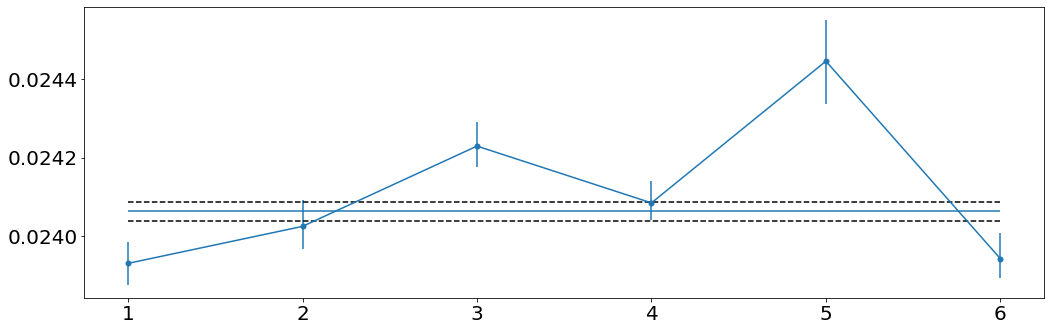

In [39]:
plt.figure(figsize=(15,5))


deltas = np.array([fitting_list_2[obs]['parameters']['rp']['value']**2 for obs in range(n_obs)])
deltas_errors = np.array([[fitting_list_2[obs]['parameters']['rp']['m_error']* rp_over_rs_new['value'] * 2,
        fitting_list[obs]['parameters']['rp']['p_error']* rp_over_rs_new['value'] * 2] 
       for obs in range(n_obs)])


mu, sigmu = weighted_avg(deltas, deltas_errors)
plt.errorbar(range(1, n_obs+1), 
             deltas, 
             yerr=deltas_errors.T,
             markersize=5, fmt='-o',)
plt.hlines(mu, 1,6 , color= p[0].get_color())
plt.hlines(mu-sigmu, 1,6, linestyle='dashed', color= 'black')
plt.hlines(mu+sigmu, 1,6, linestyle='dashed', color= 'black')
